# Plotting

This notebook will describe how to visualize data using GrandPy in different scenarios. In addition to QC plots (see the [differential expression](../notebook_01_differential_expression) and [kinetic modeling](../notebook_02_kinetic_modeling) notebooks) and vulcano/MA plots (see the [differential expression](../notebook_01_differential_expression) notebook), the plotting functions in GrandPy consist of:

- Gene-wise visualizations
- Global visualizations

# Gene-wise visualization

All functions that visualize data for a single gene start with `plot_gene_...`. We demonstrate the first few using the BANP data set [[Grand et al. (2021)]](https://www.nature.com/articles/s41586-021-03689-8). These are SLAM-seq data from multiple time points (1h, 2h, 4h, 6h and 20h) after acute depletion of BANP. We first load and preprocess this data as usual:

In [1]:
import warnings
import grandpy as gp

warnings.filterwarnings("ignore", category=UserWarning)

banp = gp.read_grand("https://zenodo.org/record/6976391/files/BANP.tsv.gz", design=("Cell", "Experimental.time", "Genotype", "duration.4sU", "has.4sU", "Replicate"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file BANP.tsv.gz was deleted after loading.


In [2]:
banp = banp.filter_genes()
banp = banp.normalize()

Refer to the [loading data](../notebook_03_loading_data_and_working_with_grandpy_objects) notebook to learn more about how to load data.

The most basic plots are just showing the raw data (from the `default_slot`, by default shown in log scale):

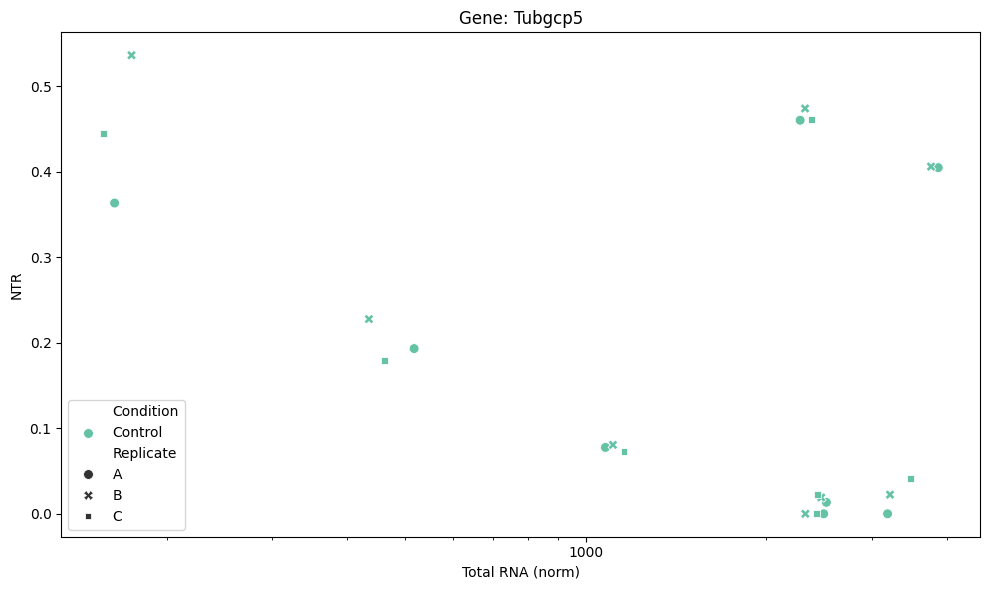

In [3]:
gp.plot_gene_total_vs_ntr(banp, gene = "Tubgcp5")

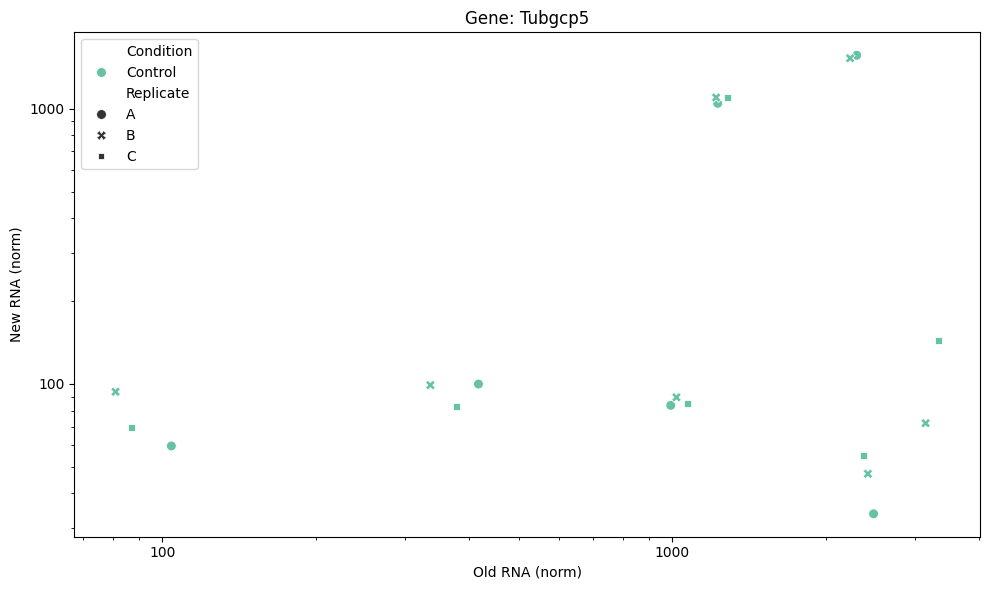

In [4]:
gp.plot_gene_old_vs_new(banp,gene = "Tubgcp5")

By default, replicates (if present in the `coldata`) will be shown as the point shapes, and conditions as colors. Here we haven't specified a Condition, so let's add one:

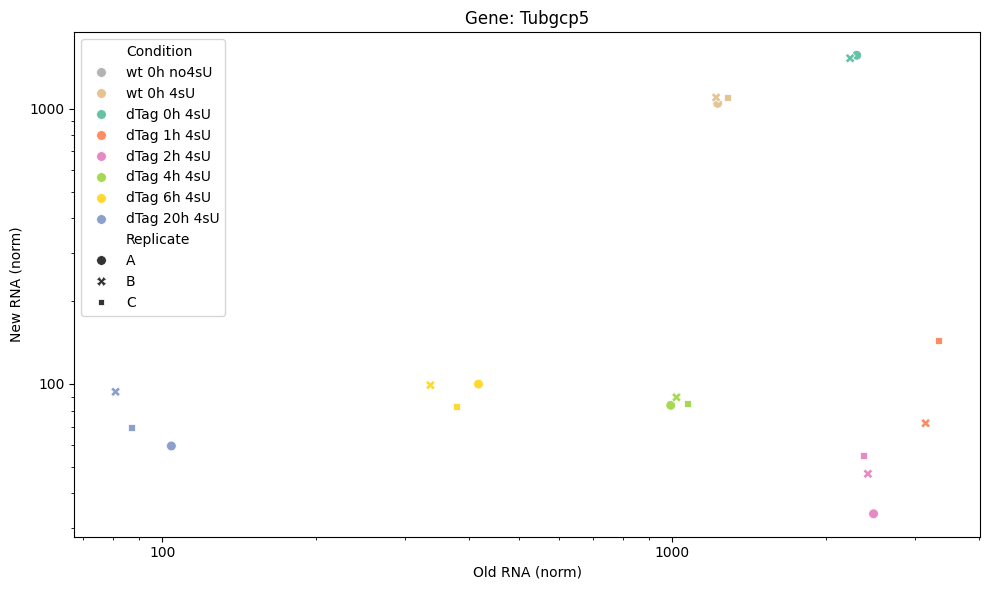

In [5]:
banp = banp.with_condition(value = ["Genotype", "Experimental.time.original", "has.4sU"])
gp.plot_gene_old_vs_new(banp, gene = "Tubgcp5")

To change the aesthetic mappings we use the `aest` parameter as follows:

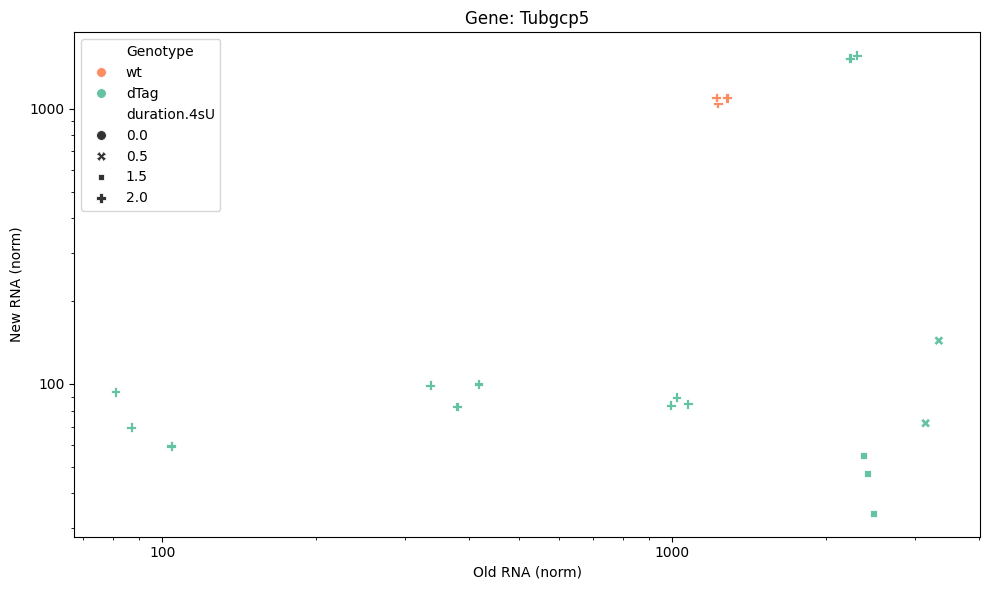

In [6]:
gp.plot_gene_old_vs_new(banp, "Tubgcp5", aest={"color": "Genotype", "shape": "duration.4sU"})

Both plotting functions also offer to plot credible intervals. These must be precomputed using `compute_ntr_ci()`.

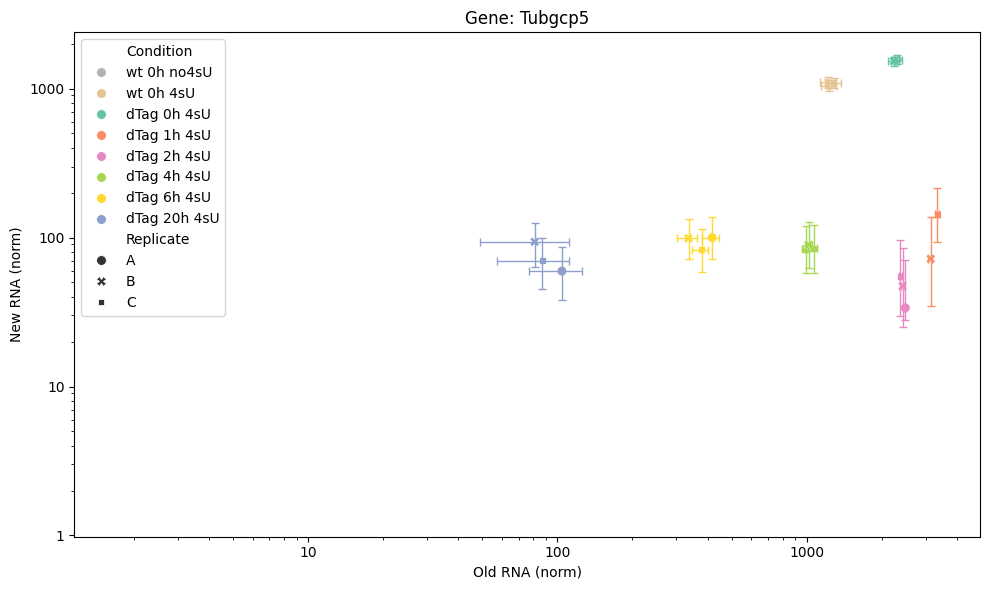

In [7]:
banp = banp.compute_ntr_ci()
gp.plot_gene_old_vs_new(banp, "Tubgcp5", show_ci=True)

These visualizations are sometimes hard to interpret. In such situations, it makes sense to only plot either old, new or total RNA on the y-axis, and group samples on the x-axis. By default, `plot_gene_groups_points()` will group the points according to `condition` (which can be changed via the group parameter). To demonstrate, we plot new RNA from the norm slot:

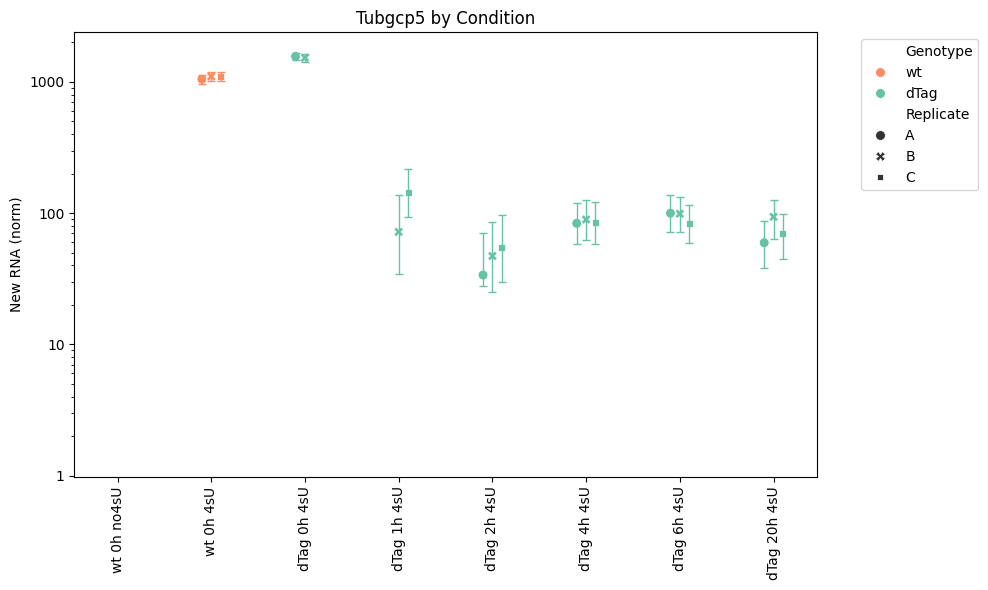

In [8]:
gp.plot_gene_groups_points(banp, "Tubgcp5", mode_slot="new_norm", show_ci=True, aest={"color": "Genotype"}, dodge="Replicate")

The last of the basic visualizations shows <span style="color:#707070;">old</span> and <span style="color:red;">new</span> RNA as bars (here we change the way the samples are labeled on the x-axis):

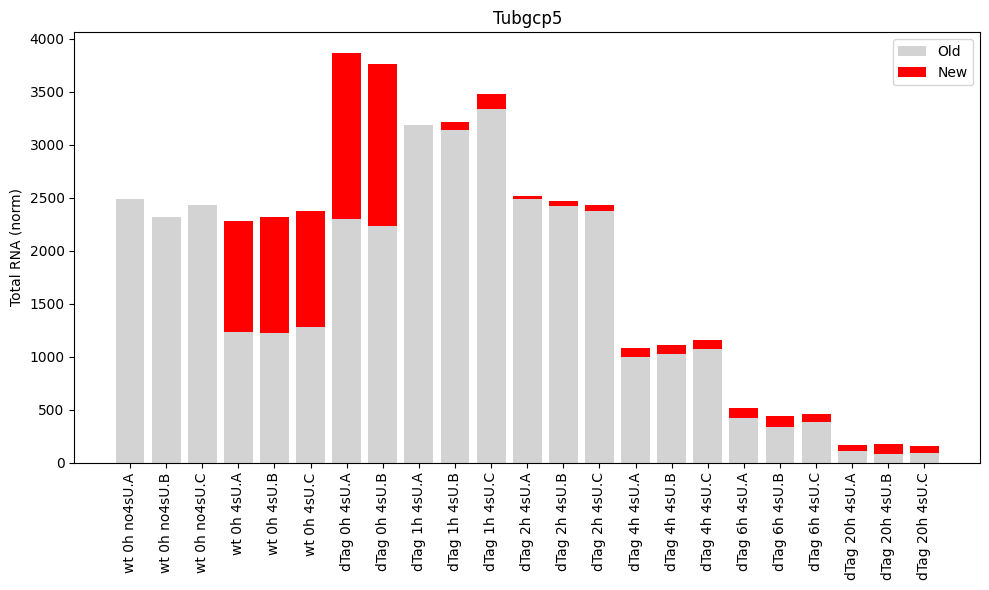

In [9]:
gp.plot_gene_groups_bars(banp, "Tubgcp5", x_labels="Condition + '.' + Replicate")

GrandPy also provides more sophisticated plotting function for time courses. A time course can either consist of several snapshots or it can be a progressive labeling time course (i.e. labeling was started at the same time point for each sample, or, in other words, the experimental time is equal to the labeling time). For snapshot data, we can use `plot_gene_snapshot_timecourse()`. This function will plot time course per `condition`, and right now each time point belongs to its own condition as defined above. Thus, we will just remove the condition for now. Furthermore, the wt Genotype doesn’t have annotated experimental times, so we remove these samples as well:

In [10]:
banp = banp[:, banp.coldata["Genotype"] == "dTag"]
banp = banp.with_condition(None)

For `plot_gene_snapshot_timecourse()` we need to define the time parameter corresponding to the experimental time, which is here the time since depleting BANP:

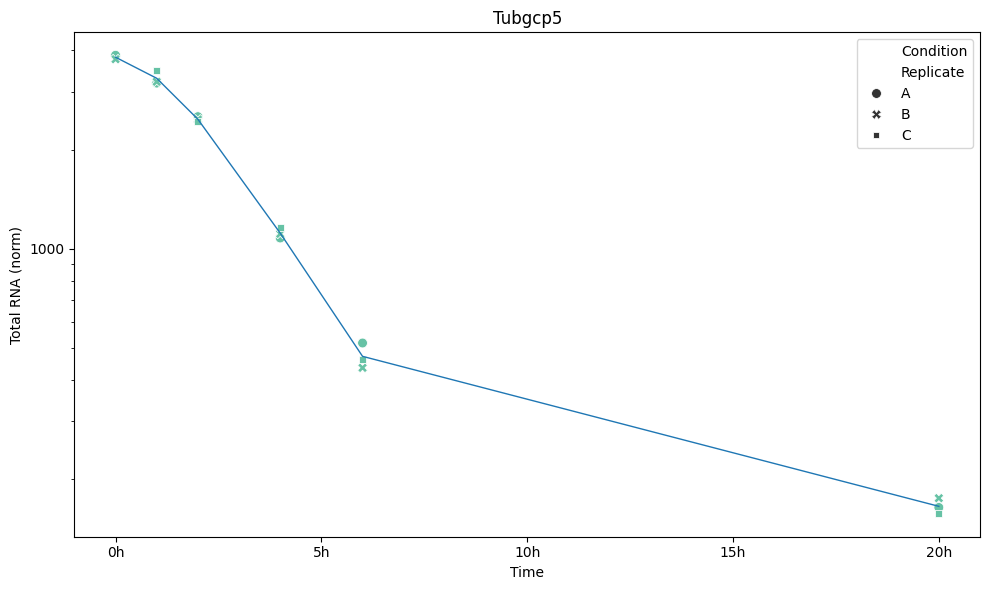

In [11]:
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time")

We can also change this to not plot in log scale, plot new RNA and show credible intervals:

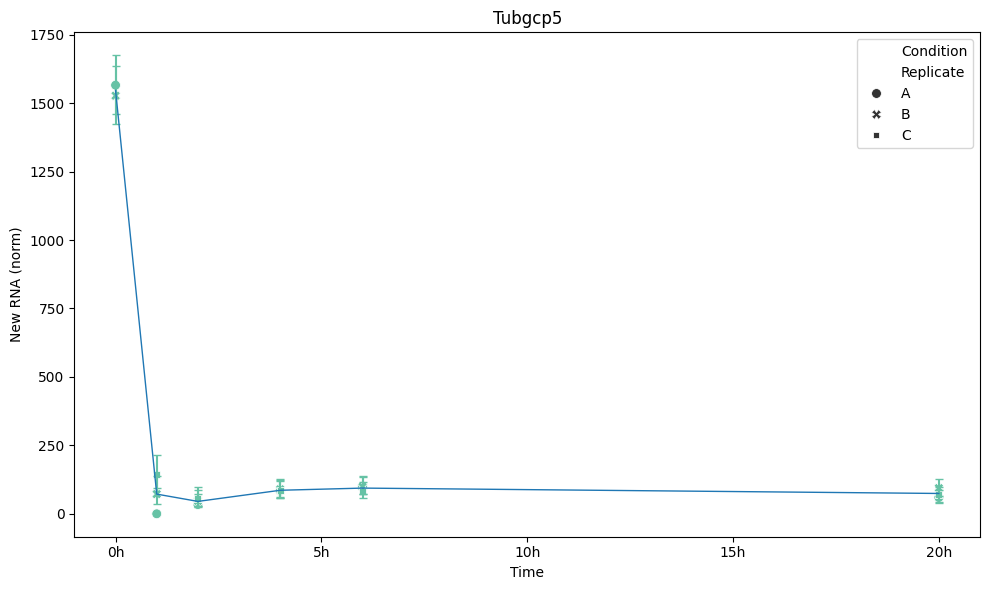

In [12]:
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time", log=False, mode_slot="new_norm", show_ci=True)

If you have multiple conditions, it will automatically show them as colors (here we don’t have conditions, so we just treat the replicates as separate conditions; we also show the NTR instead of new RNA):

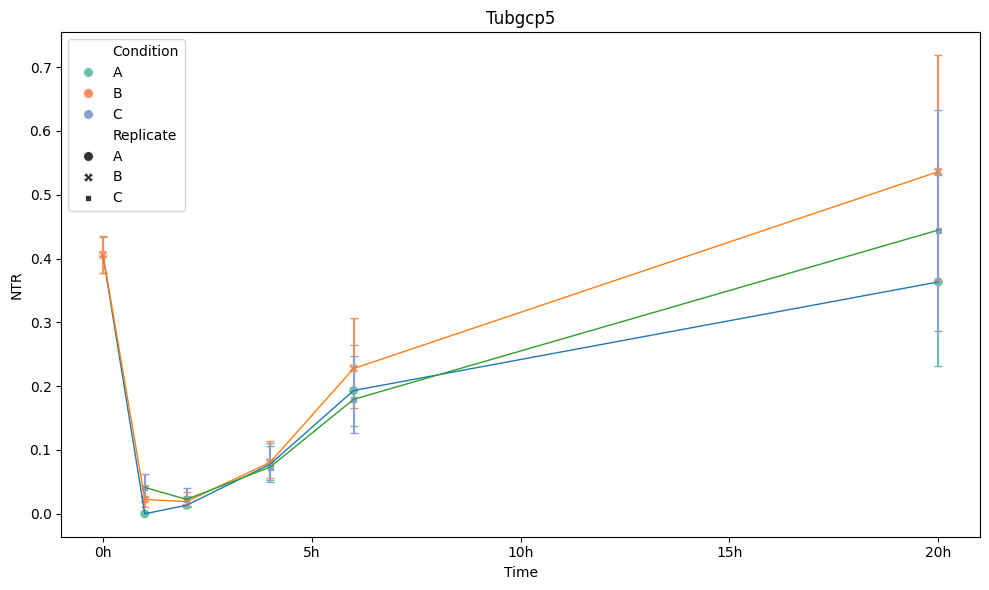

In [13]:
banp = banp.with_condition("Replicate")
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time", mode_slot="ntr", show_ci=True)

These data consist of a timecourse of several snapshots. There is also another kind of timecourse: progressive labeling. This means that the 2h time point also had 2h of labeling, and the 4h timepoint had 4h of labeling etc. Such data can be visualized using `plot_gene_progressive_timecourse()`. To demonstrate this, we first load and process the data set from [[Finkel et al. (2021)]](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infected with SARS-CoV-2 for different periods of time.

In [14]:
sars = gp.read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: gp.classify_genes(df, cg_name="Viral"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


In [15]:
sars = sars.filter_genes().normalize().compute_ntr_ci()

Now we can use it to plot time courses. The function will generate a plot for each `condition`. Just like above, here we will also plot credible intervals of the NTR quantification. In addition to data points, the plotting function will also show the model fit. For that to work properly here, it is important to specify the `steady_state`. For more on this, see the [kinetic modeling notebook](../notebook_02_kinetic_modeling).

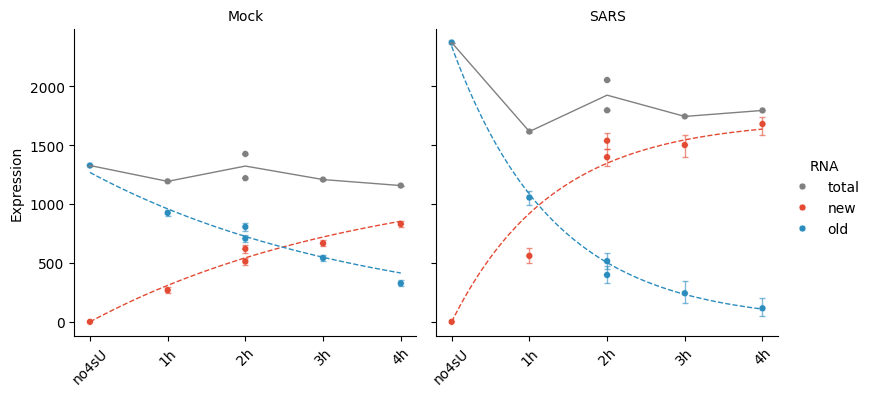

In [16]:
gp.plot_gene_progressive_timecourse(sars, "SRSF6", show_ci = True, steady_state={"Mock": True,"SARS": False})

We can also fit the kinetic model using the Bayesian method (inherently assumes steady state, which is not appropriate for the “SARS” condition). <span style="color:red;">Note that the visualization changes to indicate that this method does not use the quantification of RNA abundances at all.

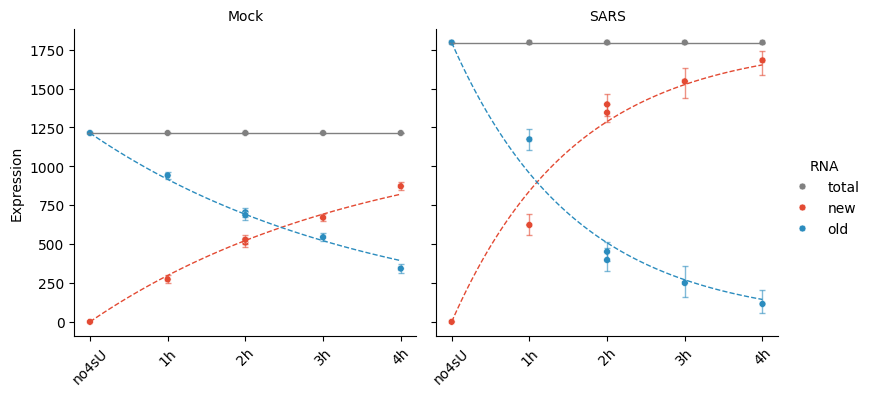

In [17]:
gp.plot_gene_progressive_timecourse(sars, "SRSF6", fit_type="ntr", show_ci = True)

Note that the SARS condition is not fit well.

# Global visualtizations

# plot scatter

Scatter plots are frequently used to provide a global overview over two variables. A straight-forward example is to compare expression values from two samples (i.e., here the x and y parameters are sample names from the data set):

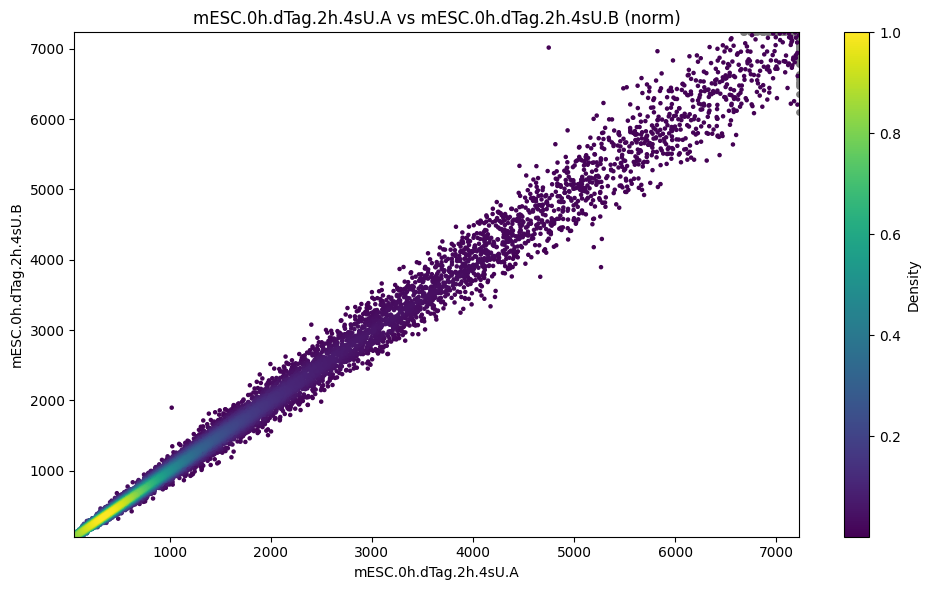

In [18]:
gp.plot_scatter(banp, x="mESC.0h.dTag.2h.4sU.A",y="mESC.0h.dTag.2h.4sU.B")

Note that `plot_scatter()` automatically cuts outliers (shown in the upper right corner in gray) to focus on the bulk of the genes (see below how to modify this behavior), and that it shows dense regions (with many genes) by brighter colors.

`plot_scatter()` can also display results from analyses (see the [differential expression](../notebook_01_differential_expression) and [kinetic modeling](../notebook_02_kinetic_modeling) notebooks for more information on analyses). To demonstrate, we first create some analysis results:

In [19]:
contrasts = banp.get_contrasts(contrast=["Experimental.time.original", "0h"])
banp = banp.compute_lfc(prefix="total", contrasts=contrasts)
banp = banp.pairwise_deseq2(prefix="total", contrasts=contrasts)

Using parametric fit type.


Running Wald tests...
... done in 0.46 seconds.

Running Wald tests...
... done in 0.54 seconds.

Running Wald tests...
... done in 0.42 seconds.

Running Wald tests...
... done in 0.45 seconds.

Running Wald tests...
... done in 0.44 seconds.



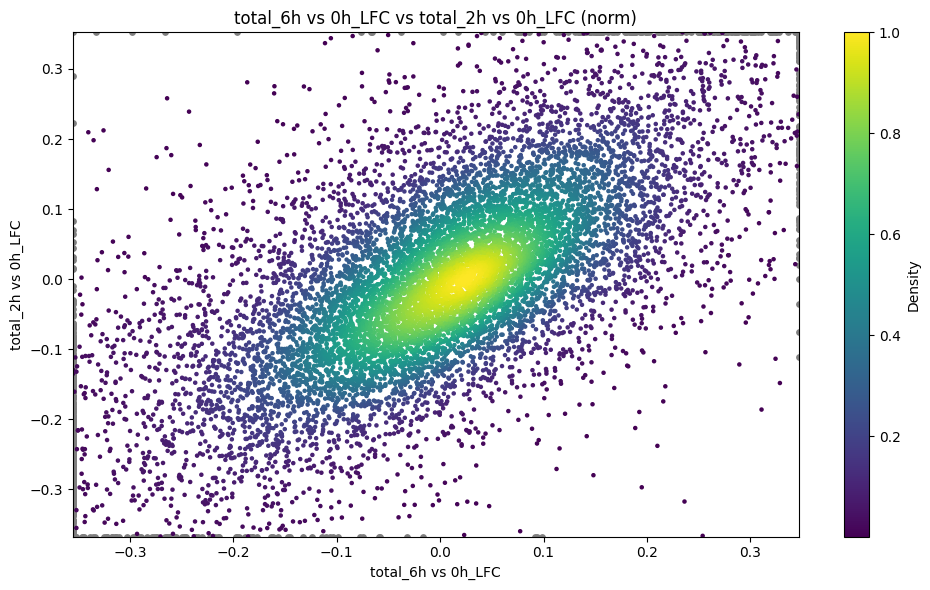

In [20]:
banp.get_analysis_table(with_gene_info=False)
gp.plot_scatter(banp,x="total_6h vs 0h_LFC",y="total_2h vs 0h_LFC")

Here, both the `x` and `y` parameter to `plot_scatter` are character strings that are (i) sample (or cell, in case of single cell data) names(like mESC.0h.dTag.2h.4sU.A) or(ii) fully qualified analysis results(like "total_6h vs 0h_LFC"). A fully qualified analysis result is the analysis name(for "total_6h vs 0h_LFC" this is "total_6h vs 0h", which is build by the `compute_lfc` function used above from the `prefix` parameter - "total" - and the name in the used contrast matrix - "6h vs 0h") followed by a underscore("_") and the name of the computed statistic (here "LFC"). If you don't know what is available so far in your object, call `banp.nalyses`. You can also do , if you don't want to use the `plot_vulcano` function, see the [differential expression notebook](../notebook_01_differential_expression):

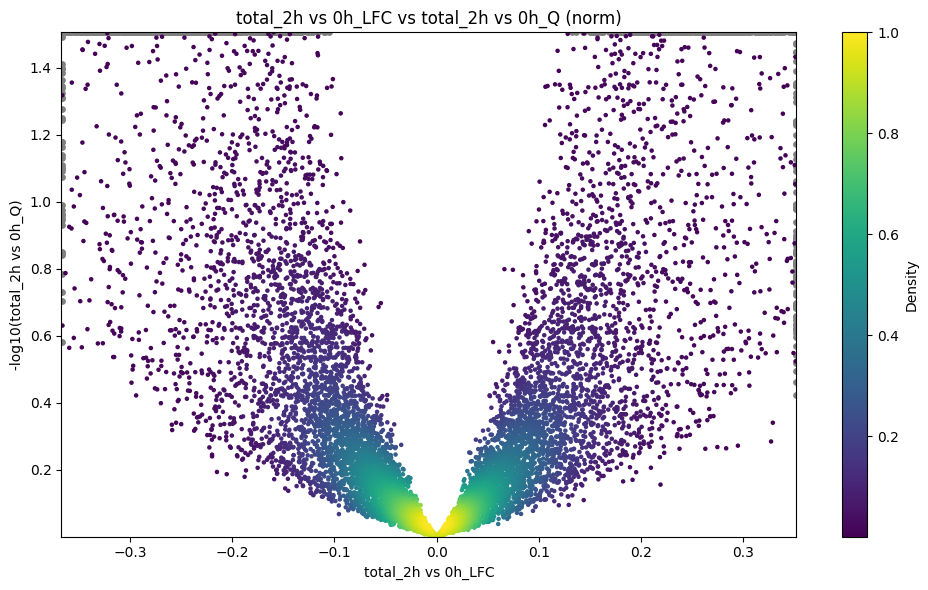

In [21]:
gp.plot_scatter(banp, x="total_2h vs 0h_LFC",y="total_2h vs 0h_Q", neg_log_y=True, y_axis_label="-log10(total_2h vs 0h_Q)")

Axes can also be plotted in log scale(there are also parameters called `log_x`, `log_y`, `neg_log_x` and `neg_log_y`), and it is possible to change the axis labels.

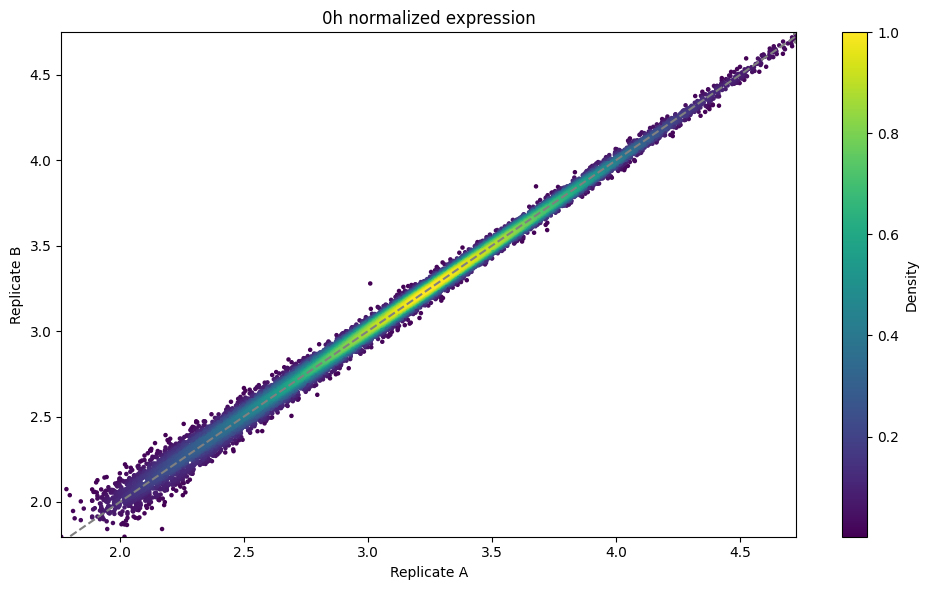

In [22]:
gp.plot_scatter(banp, x="mESC.0h.dTag.2h.4sU.A", y="mESC.0h.dTag.2h.4sU.B", x_axis_label="Replicate A", y_axis_label="Replicate B", log=True, title="0h normalized expression", diagonal=True)

You might have noticed that the outlier filtering for one of the plots above(log2 fold change comparison) was too stringent. How stringently outliers are filtered is defined via the `remove_outlier` parameter(the higher, the more points are included and not defined as outliers), or limits can be defined directly via `x_limit`, `y_limit` or, if these are the same, via `limit`. We can also use the `matplotlib.subplots` method and define the axes to the `matplotlib_ax` parameter to combine plots. When I combine plots, I don't like the colorbar, so we can just set the `colorbar` parameter to False.

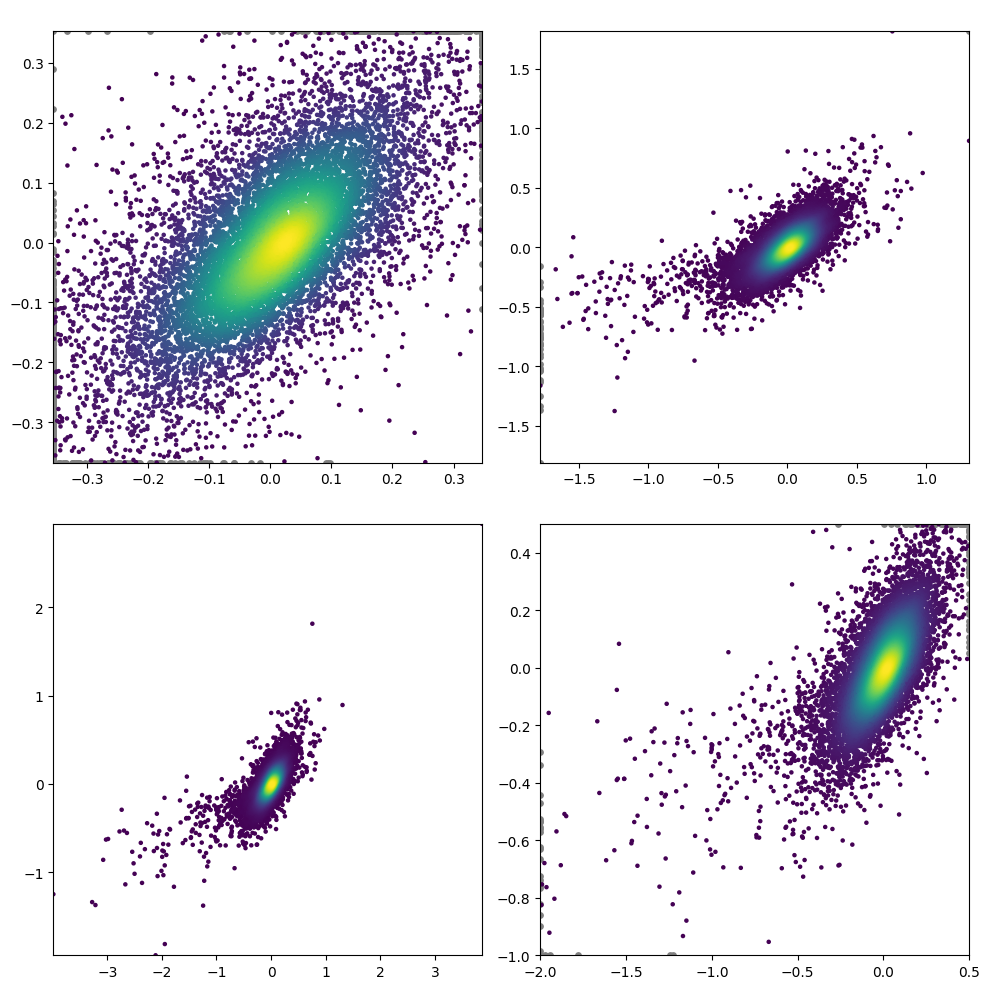

In [23]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

x="total_6h vs 0h_LFC"
y="total_2h vs 0h_LFC"
gp.plot_scatter(banp, x=x, y=y, x_axis_label="", y_axis_label="", title=" ", figsize=(5, 5), colorbar=False, matplot_ax=axes[0])
gp.plot_scatter(banp, x=x, y=y, x_axis_label="", y_axis_label="", title=" ", remove_outlier=10, figsize=(5, 5), colorbar=False, matplot_ax=axes[1])
gp.plot_scatter(banp, x=x, y=y, x_axis_label="", y_axis_label="", title=" ", remove_outlier=False, figsize=(5, 5), colorbar=False, matplot_ax=axes[2])
gp.plot_scatter(banp, x=x, y=y, x_axis_label="", y_axis_label="", title=" ", x_limit=(-2, 0.5), y_limit=(-1, 0.5), colorbar=False, figsize=(5, 5), matplot_ax=axes[3])

plt.tight_layout()
plt.show()

#TODO 2. teil fehlt

# plot heatmap

While scatter plots are frequently used to provide a global overview over two variables, you can use heatmaps to handle more than two variables. GrandPy provides the `plot_heatmap`.
In essence, this function does the following

1. Call the powerful `get_table` function (see the [working with data matrices and analysis results](../notebook_04_working_with_data_matrices_and_analysis_results) notebook)
2. Transform the data matrix
3. Determine reasonable colors
4. Use sns.heatmap

In [24]:
sig_genes = banp.get_significant_genes(analysis="total_6h vs 0h_LFC")
#gp.plot_heatmap(banp, genes=sig_genes)

ValueError: Output contains mixed data types (logical and numeric).